# **Imports**

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import cv
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# **Import Data as CSV**

### Check for data integrity: null/missing values and datatypes

In [2]:
fraud_df = pd.read_csv('synthetic_fraud_dataset.csv')
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

# **Exploratory Data Analysis**

### Check for patterns/correlation between certain features and Fraud

#### Total number of fraud vs. non-fraud cases

[Text(0.5, 0, 'Fraud Label (0: Not Fraud, 1: Fraud)'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims')]

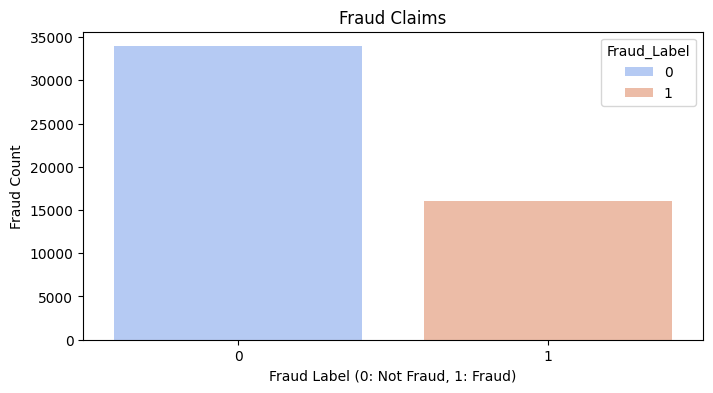

In [3]:
plt.figure(figsize=(8,4))
fraud_count = sns.countplot(fraud_df, x='Fraud_Label', palette='coolwarm', hue='Fraud_Label')
fraud_count.set(xlabel="Fraud Label (0: Not Fraud, 1: Fraud)", ylabel="Fraud Count", title="Fraud Claims")

#### Total number of fraud claims per device

[Text(0.5, 0, 'Device Type'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims per Device')]

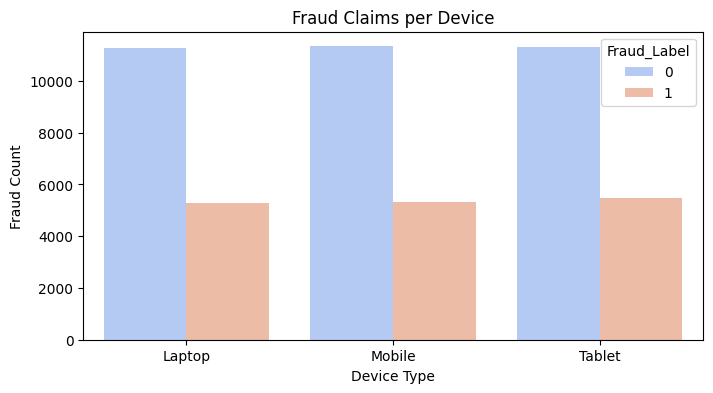

In [4]:
plt.figure(figsize=(8,4))
device_fraud = sns.countplot(fraud_df, x='Device_Type', palette='coolwarm', hue='Fraud_Label')
device_fraud.set(xlabel="Device Type", ylabel="Fraud Count", title="Fraud Claims per Device")

#### Total number of fraud claims per Authentication Method

[Text(0.5, 0, 'Authentication Method'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims per Auth Method')]

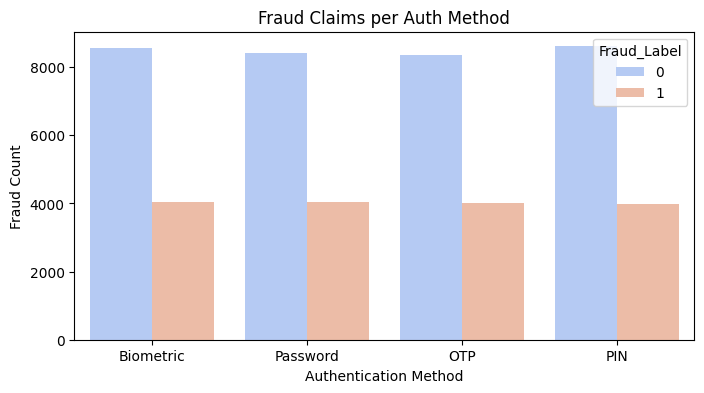

In [5]:
plt.figure(figsize=(8,4))
auth_fraud = sns.countplot(fraud_df, x='Authentication_Method', palette='coolwarm', hue='Fraud_Label')
auth_fraud.set(xlabel="Authentication Method", ylabel="Fraud Count", title="Fraud Claims per Auth Method")

In [6]:
def percentage_account(transaction, account_total):
    percentage = transaction/account_total
    return percentage*100

fraud_df["Transaction_Percentage"] = fraud_df.apply(lambda x: percentage_account(x["Transaction_Amount"], x["Account_Balance"]), axis = 1)

[Text(0.5, 0, 'Percentage of Acct Balance of Transaction'),
 Text(0, 0.5, 'Fraud'),
 Text(0.5, 1.0, 'Fraud Claims vs. % of acct Balance ')]

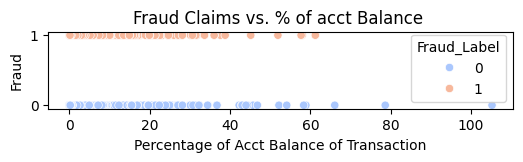

In [7]:
plt.figure(figsize=(6,1))
transactionP_fraud = sns.scatterplot(fraud_df, x='Transaction_Percentage', y='Fraud_Label', palette='coolwarm', hue='Fraud_Label')
transactionP_fraud.set(xlabel="Percentage of Acct Balance of Transaction", ylabel="Fraud", title="Fraud Claims vs. % of acct Balance ")

[Text(0.5, 0, 'Fraud Count'),
 Text(0, 0.5, 'Location'),
 Text(0.5, 1.0, 'Fraud Claims per Location')]

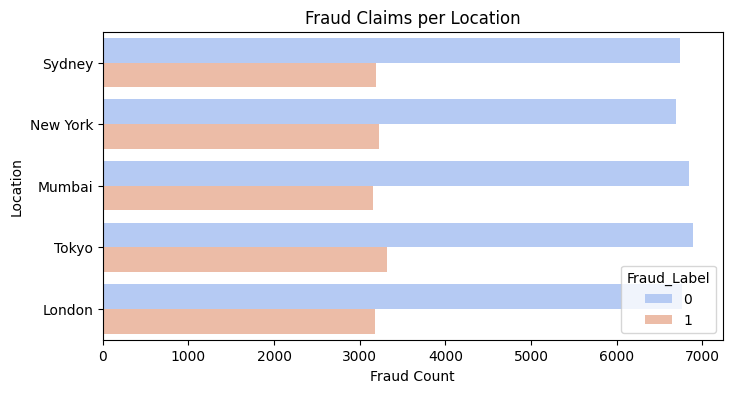

In [8]:
plt.figure(figsize=(8,4))
location_fraud = sns.countplot(fraud_df, y='Location', palette='coolwarm', hue='Fraud_Label')
location_fraud.set(xlabel="Fraud Count", ylabel="Location", title="Fraud Claims per Location")

#### Distribution of Fraud/Non-fraud claims vs Transaction Distance

<Figure size 600x100 with 0 Axes>

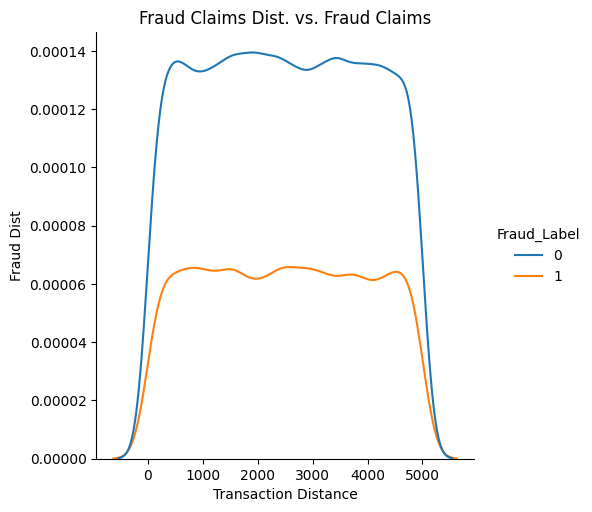

In [9]:
plt.figure(figsize=(6,1))
distance_fraud = sns.displot(fraud_df, x='Transaction_Distance', hue='Fraud_Label', kind="kde")
distance_fraud.set(xlabel="Transaction Distance", ylabel="Fraud Dist", title="Fraud Claims Dist. vs. Fraud Claims")

Feature Engineering: Splitting Date-time from string into individual date-time features such as Year, Month, Date, Hour, Minute, Second.

In [10]:
def ymd_hms(row):
    col = row["Timestamp"].split()

    ymd_format = col[0].split('-')
    hms_format = col[1].split(':')

    year, month, date = int(ymd_format[0]), int(ymd_format[1]), int(ymd_format[2])
    hour, minute, second = int(hms_format[0]), int(hms_format[1]), int(hms_format[2])

    row['Year'] = year
    row['Month'] = month
    row['Date'] = date
    row['Hour'] = hour
    row['Minute'] = minute
    row['Second'] = second

    return row

In [16]:
fraud_df = fraud_df.apply(lambda x: ymd_hms(x), axis=1)

#### Fraud/Non-fraud claims per month

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims per Month')]

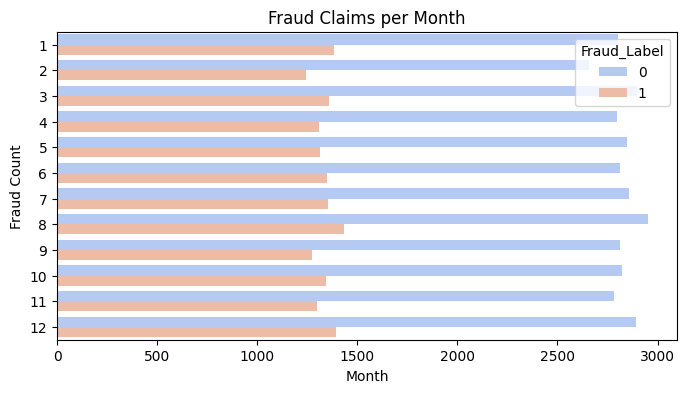

In [17]:
plt.figure(figsize=(8,4))
month_fraud = sns.countplot(fraud_df, y='Month', palette='coolwarm', hue='Fraud_Label')
month_fraud.set(xlabel="Month", ylabel="Fraud Count", title="Fraud Claims per Month")

#### Total number of fraud claims per purchase/merchant type.

[Text(0.5, 0, 'Merchant Type'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims per Merchant')]

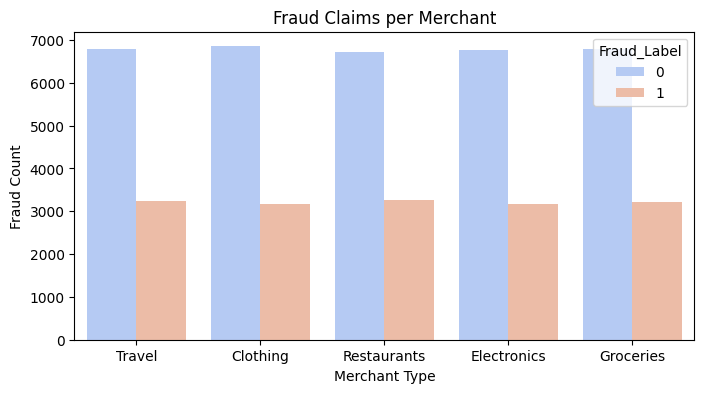

In [29]:
plt.figure(figsize=(8,4))
merchant_fraud = sns.countplot(fraud_df, x='Merchant_Category', palette='coolwarm', hue='Fraud_Label')
merchant_fraud.set(xlabel="Merchant Type", ylabel="Fraud Count", title="Fraud Claims per Merchant")

<Figure size 600x100 with 0 Axes>

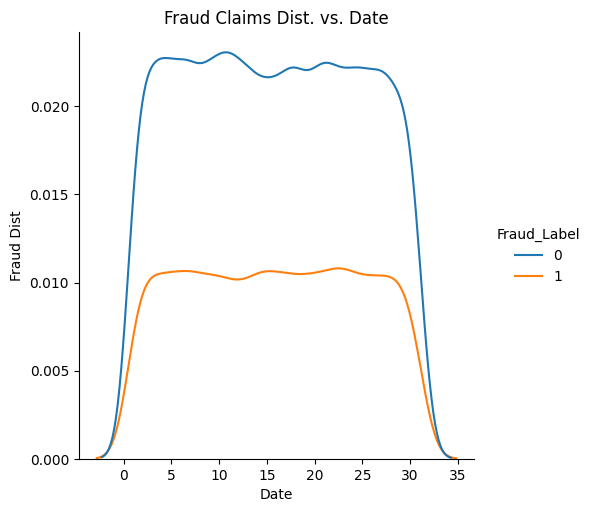

In [23]:
plt.figure(figsize=(6,1))
hour_fraud = sns.displot(fraud_df, x='Date', hue='Fraud_Label', kind="kde")
hour_fraud.set(xlabel="Date", ylabel="Fraud Dist", title="Fraud Claims Dist. vs. Date")

<Figure size 600x100 with 0 Axes>

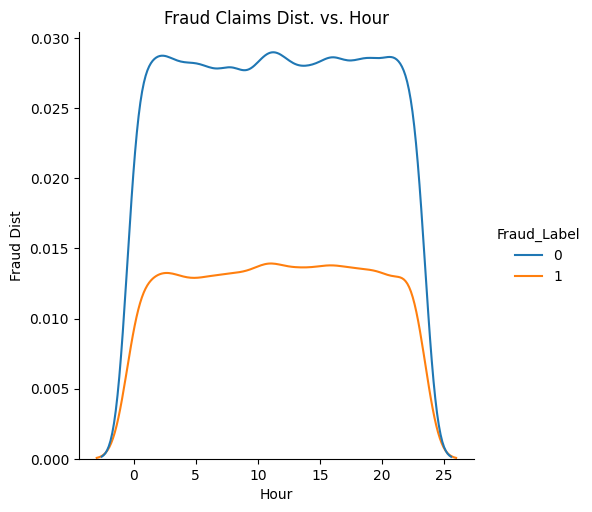

In [18]:
plt.figure(figsize=(6,1))
hour_fraud = sns.displot(fraud_df, x='Hour', hue='Fraud_Label', kind="kde")
hour_fraud.set(xlabel="Hour", ylabel="Fraud Dist", title="Fraud Claims Dist. vs. Hour")

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [24]:
x=fraud_df.drop(["Transaction_ID","User_ID","Fraud_Label","Minute","Second","Date"],axis=1)
y=fraud_df['Fraud_Label']

In [25]:
x.columns

Index(['Transaction_Amount', 'Transaction_Type', 'Timestamp',
       'Account_Balance', 'Device_Type', 'Location', 'Merchant_Category',
       'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Transaction_Percentage', 'Year', 'Month', 'Hour'],
      dtype='object')

In [70]:
def preprocess_pipeline(x, drop=[], categorical=[], label=[], numerical=[]):

    x = x.drop(drop, axis=1)

    # Define the custom order for the 'Authentication_Method' column
    auth_order = ['PIN', 'Password', 'OTP', 'Biometric']
    auth_encoder = OrdinalEncoder(categories=[auth_order])

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical),
            ('cat', OneHotEncoder(), categorical),
            ('auth', auth_encoder, label)
    ])

    x = preprocessor.fit_transform(x)

    # Get feature names
    num_features = numerical
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical)
    auth_features = label

    # Combine all feature names
    feature_names = list(num_features) + list(cat_features) + auth_features

    # Convert to DataFrame to keep column names
    x = pd.DataFrame(x, columns=feature_names)



    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    data_dmatrix = xgb.DMatrix(data=x,label=y)

    params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

    xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)
    
    # declare parameters
    params = {
                'objective':'binary:logistic',
                'max_depth': 4,
                'alpha': 10,
                'learning_rate': 1.0,
                'n_estimators':100
            }         
                    
    # instantiate the classifier 
    xgb_clf = XGBClassifier(**params)

    # fit the classifier to the training data
    xgb_clf.fit(x_train, y_train)
    y_pred = xgb_clf.predict(x_test)
    print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

    return(xgb_cv.head(), xgb_clf, x_train, x_test, y_train, y_test)


In [ ]:
# Define the columns
categorical_columns = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type']
label_encoded_column = 'Authentication_Method'
numerical_columns = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age', 'Transaction_Distance', 'Risk_Score', 'Transaction_Percentage', 'Year', 'Month', 'Hour']

# Define the custom order for the 'Authentication_Method' column
auth_order = ['PIN', 'Password', 'OTP', 'Biometric']
auth_encoder = OrdinalEncoder(categories=[auth_order])

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns),
        ('auth', auth_encoder, [label_encoded_column])
    ])

x = preprocessor.fit_transform(x)


In [51]:
# Get feature names
num_features = numerical_columns
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
auth_features = [label_encoded_column]

# Combine all feature names
feature_names = list(num_features) + list(cat_features) + auth_features

# Convert to DataFrame to keep column names
x = pd.DataFrame(x, columns=feature_names)

In [52]:
x

,Transaction_Amount,Account_Balance,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Transaction_Percentage,Year,...,Merchant_Category_Clothing,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Amex,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,Authentication_Method
0,-0.604147,1.492310,-0.120121,1.289836,0.704581,-0.797272,-1.120662,1.208753,-0.249045,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0
1,-0.995285,0.884250,1.365176,1.580752,1.411665,0.956729,-0.205135,-1.409646,-0.270057,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,-0.713888,-1.693492,1.612725,-1.451837,1.411665,1.536564,-0.409067,1.176089,0.660570,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0
3,1.569711,0.921870,0.127429,-0.514864,1.411665,-0.637818,-0.823374,1.014502,-0.101643,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,-0.690380,1.462460,1.612725,0.519293,1.411665,0.289918,-1.062541,-0.415801,-0.253551,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.550847,0.927187,-1.357868,0.945871,0.704581,-0.318908,-0.666869,-1.224082,-0.240945,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49996,0.270949,-0.747642,1.365176,1.270880,1.411665,-0.391388,0.039220,-0.473486,-0.046945,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
49997,-0.277556,-0.708537,-1.605418,0.805470,-0.002503,-0.086974,1.516939,0.062357,-0.147831,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
49998,-0.349805,0.612013,1.365176,-0.091822,1.411665,-0.695801,1.655865,0.711483,-0.222017,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0


In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:


# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [55]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(40000, 34)
(40000,)
(10000, 34)
(10000,)


In [ ]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [57]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.522001,0.002626,0.502204,0.002146
1,0.999662,0.000261,0.999444,0.000439
2,0.999618,0.000304,0.999399,0.000476
3,0.999653,0.000250,0.999438,0.000441
4,0.999638,0.000261,0.999403,0.000461


In [ ]:


# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }         
                  
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(x_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_clf.predict(x_test)

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.9995


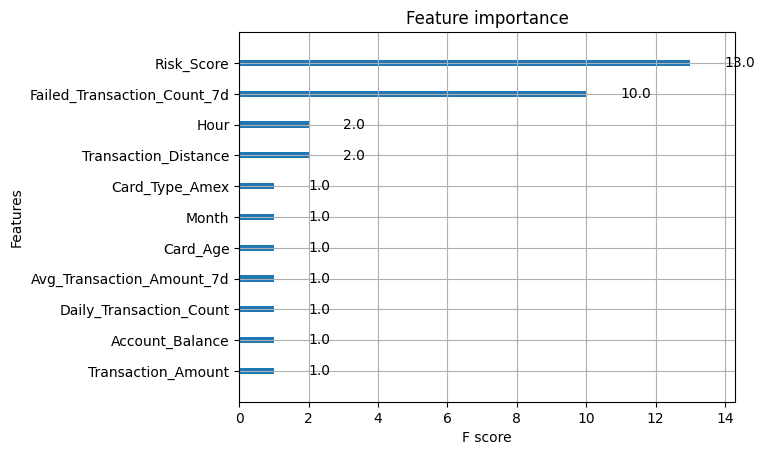

<Figure size 1600x1200 with 0 Axes>

In [60]:
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()

<Figure size 600x100 with 0 Axes>

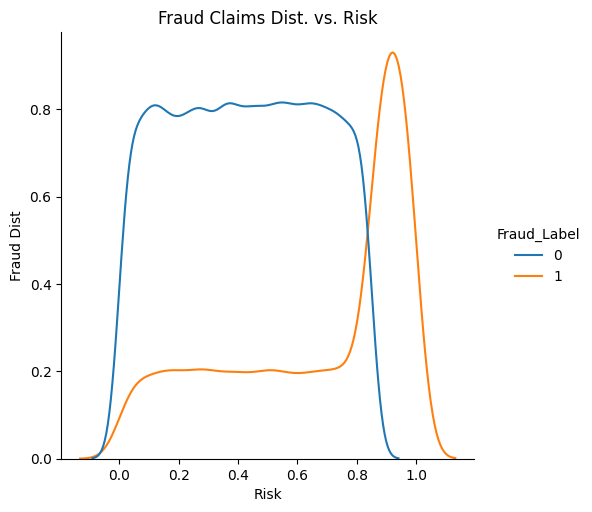

In [62]:
plt.figure(figsize=(6,1))
risk_fraud = sns.displot(fraud_df, x='Risk_Score', hue='Fraud_Label', kind="kde")
risk_fraud.set(xlabel="Risk", ylabel="Fraud Dist", title="Fraud Claims Dist. vs. Risk")

In [80]:
drop = ["Transaction_ID","User_ID","Fraud_Label","Minute","Second","Date","Risk_Score"]
categorical_columns = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type']
label_encoded_column = ['Authentication_Method']
numerical_columns = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age', 'Transaction_Distance', 'Transaction_Percentage', 'Year', 'Month', 'Hour']
y=fraud_df['Fraud_Label']

output = preprocess_pipeline(fraud_df, drop, categorical_columns, label_encoded_column, numerical_columns)

XGBoost model accuracy score: 0.8752


In [81]:
output[0]

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.530319,0.002161,0.497193,0.003124
1,0.822179,0.003050,0.809249,0.004715
2,0.826805,0.002354,0.808404,0.004251
3,0.830470,0.002523,0.809510,0.004172
4,0.833193,0.003097,0.808201,0.003537


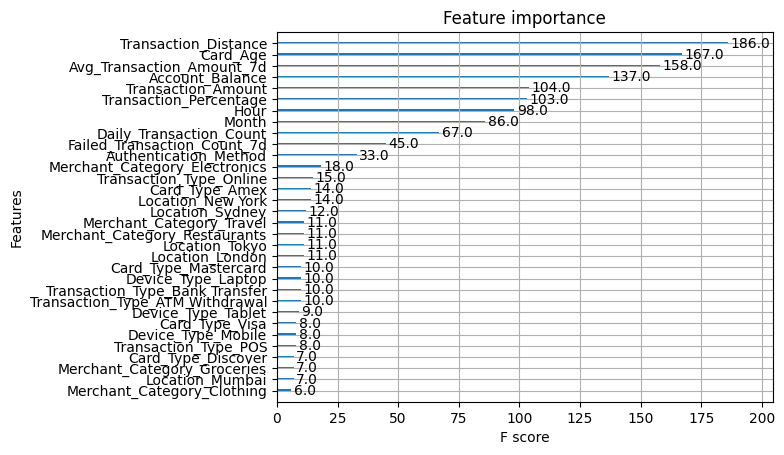

<Figure size 1600x1200 with 0 Axes>

In [82]:
xgb.plot_importance(output[1])
plt.figure(figsize = (16, 12))
plt.show()